# Welcome to part 4 of the NtupleAnalysisUtils Tutorial! 

In this part, we will learn how to use `NtupleAnalysisUtils` to perform histogramming tasks on a set of input trees.
This strongly builds on the key concepts for I/O introduced in part 3, as well as the `Plot` class and populator mechanics discussed in parts 1 and 2. 

We will individually show all the building blocks and demonstrate them within the scope of this notebook.

Then, we will put them together and be able to run an entire event loop, fully configurable, within a single line! 

### Notebook setup

The following lines are *only* needed within the Jupyter world to set up the package. They are not needed in normal usage (unless you wish to use NtupleAnalysisUtils within a Swan notebook)

In [1]:
%alias getFromEOS if [[ -e %l ]]; then echo "Obtaining %l via cp"; cp -r %l . ;  else echo "Obtaining %l via xrdcp" ; xrdcp -r --force root://eosuser.cern.ch/%l .  ; fi 

In [2]:
import ROOT

Welcome to JupyROOT 6.20/06


In [3]:
getFromEOS /eos/user/g/goblirsc/NtupleAnalysisUtils/CI_Artifacts/lib/libNtupleAnalysisUtils.so

Obtaining /eos/user/g/goblirsc/NtupleAnalysisUtils/CI_Artifacts/lib/libNtupleAnalysisUtils.so via cp


In [4]:
getFromEOS /eos/user/g/goblirsc/NtupleAnalysisUtils/CI_Artifacts/include

Obtaining /eos/user/g/goblirsc/NtupleAnalysisUtils/CI_Artifacts/include via cp


In [5]:
%%cpp
#pragma cling add_include_path("include/")
gSystem->Load("libNtupleAnalysisUtils");

In [6]:
%%cpp
#include "NtupleAnalysisUtils/NTAUTopLevelIncludes.h"

In [7]:
%%cpp
SetAtlasStyle();


Applying ATLAS style settings...



In [8]:
getFromEOS /eos/user/g/goblirsc/NtupleAnalysisUtils/Tutorials/DemoTree.root

Obtaining /eos/user/g/goblirsc/NtupleAnalysisUtils/Tutorials/DemoTree.root via cp


### Known limitations of this notebook

This notebook lives in cling, which is an interpreter for C++ syntax provided with ROOT. 

As a consequence, we can not provide the real workflow of coding - compiling - running you would be using in practice. 
On the positive side, with the interpreted flavour it is very easy to manipulate things in place and experiment! 

Another consequence is that all C++ cells are wrapped in a "%%cpp" 'cell magic', which makes ROOT interpret them. 
This is of course another thing you would not do in 'real life'. 

I tried to provide compiled versions of most of the examples within the [examples](https://gitlab.cern.ch/goblirsc/NtupleAnalysisUtils/-/blob/master/examples/) folder of the repository - so you can still try these out in the standard workflow, just without the inline documentation! 

## Important - Requirements 
---

Another thing to be aware of is that, since we are loading a pre-compiled C++ library, the **version of ROOT** you set up **SWAN** with must match the ROOT version that was used to compile the compiled C++ library provided for this tutorial. 

The library will always be based on the latest AnalysisBase. At the time of writing, this is **ROOT 6.20.06**, which you can get by **setting up version "97a" of the stack in the initial SWAN window**. 

---
You can find the "correct" LCG release (stack version) for each ROOT by looking at [this page](http://lcginfo.cern.ch/pkg/ROOT/) and clicking on the version you need. 

If the versions do not match, the line above in Cell number 5 should print an error. If you don't see one, things are probably fine! 


# Getting started - what do we want to do? 

In this tutorial, we want to perform a "histogramming" workload. 

This means we have a set of input ntuples - each containing, for example, simulated or real collision data - available to us, and we wish to extract a number of histograms from them. 

We will usually want to have not just one big histogram, but one 'version' for each MC process as well as the data. This motivates thinking of our inputs as being split into distinct "samples". 

Then, typically, we will want to apply some event selections - for example, to further categorize our events, or even in an exploratory fashion to tune our event selection.

At the same time, we rarely only need one single histogram per sample - we may want to check a number of observables, or apply different weights, or apply systematic variations... 


There are a number of conventional methods of doing this. These include for example: 
- Practical exerience shows there is still a large user-base of `TTree::Draw` and `TTree::Project`. These are attractive due to the low syntax overhead involved, and the good execution speed for a single run. The major downside is that it becomes diffcult to process multiple histograms, each possibly for multiple selections, without repeating the event loop several times. As a result, performance is usually only competetive for very limited tasks (for example filling just a single plot).   
- ROOT's `TSelector` provides some help in accessing the tree content and looping over it. Booking and maintaining many histograms however quickly becomes tedious, and requires manual coding within the event loop. 
- More modern approaches as Root's DataFrames address many shortcomings of the above. Adoption is still limited, but growing. 

`NtupleAnalysisUtils` offers a histogramming solution conceptually close to the ROOT data frames, with the advantage of seamless integration with all the other package tools. 

As discussed in part 2 of the tutorial, ROOT histograms in `NtupleAnalysisUtils` are packaged in `Plot` objects and their content is obtained using `Populators`. This also holds here - the entire event-loop implementation is hidden from the user, who just has to use a special `RunHistoFiller` populator describing the desired workload. 



## The building blocks for a histogramming task

To run a histogramming task in `NtupleAnalysisUtils`, we need to specify four building blocks.

Let's identify these by looking at a typical call to the familiar `TTree::Draw`: 
This could look like 

```MyTree->Draw("SomeVariable >> H (200,1,200)", "someSelection * someWeight");```

- `MyTree` describes **what we run on** - the source of our input events to loop over  
- `someSelection` allows us to steer **when to fill** our histogram - we can specify an additional event selection or -categorisation 
- `SomeVariable` and `someWeight` together describe **how to fill** our histogram (implicitly, `TTree::Draw` will interpret this as a is a `TH1::Fill` call)
- Finally, `H (200,1,200)` describes how our output histogram should be binned. In general, we need to specify **what to fill** (also can go beyond histograms, e.g. TEfficiency, TProfile, TGraph, ...) 


The `RunHistoFiller` populator in `NtupleAnalysisUtils` takes exactly the same four pieces to define its work. 

Let's now walk through each of them, before diving more deeply into the usage of the populator itself!


## What to run on - the `Sample` class

The purpose of the [Sample](https://gitlab.cern.ch/goblirsc/NtupleAnalysisUtils/-/blob/master/NtupleAnalysisUtils/HistoFiller/Sample.h) class is to collect a list of trees to parse in order to obtain our histogram. 

Each individual input tree is represented by an [InputFile](https://gitlab.cern.ch/goblirsc/NtupleAnalysisUtils/-/blob/master/NtupleAnalysisUtils/HistoFiller/Sample.h) object, packaging a **file location** and a **tree name** within the provided file. 
Optionally, it is also possible to specify a special event selection requirement just for the current tree. This is for example useful if we need to remove overlap between different MC samples via some kinematic cut, or if we want to split our sample into a training and test dataset for ML applications. 

The `Sample` and the `InputFile` are templated to the class we use to represent the input tree - usually inheriting from the `NtupleBranchMgr`. Please see the previous part of the tutorial for how to automatically generate such a class! 

For our test, let's quickly run the equivalent of the code generation by hand (as the program is not available within this notebook), to have something to play with. 

In [9]:
%%cpp -d 

/// put this in a method to avoid cluttering our notebook
void generateTree(){
    TFile* fin = TFile::Open("DemoTree.root", "READ");
    TTree* theTree = dynamic_cast<TTree*>(fin->Get("SM4L_Nominal")); 
    NtupleBranchMgr t(theTree); 
    /// discover all branches 
    t.getMissedBranches(theTree);
    /// now auto-generate code for a class with all known branches.
    /// Place it in the current directory (second arg). 
    t.GenerateManagerClass("MyAnalysisTree");
}

In [10]:
%%cpp 
generateTree();

In [11]:
%%cpp
#include "./MyAnalysisTree.h"

Ok, now we can instantiate ourselves a sample. 

I will show of two ways of doing this. The first one is by providing a list of `InputFile` objects, one for each tree. For our demo, we will just have one of them: 

In [12]:
%%cpp -d

/// The Sample is templated to the type of object it is supposed to load the tree as. 
/// This will usually be "your" auto-generated analysis tree class inheriting from NtupleBranchMgr
Sample<MyAnalysisTree> makeSample_v1(){

    /// first, declare & define a vector of input files to process - just one in this case. 
    /// Note that the InputFile is also templated to the object it should try to load for processing. 
    std::vector<InputFile<MyAnalysisTree>> myFiles{ 
        /// An input file is specified by providing a file location and a tree name to load from within the file
        InputFile<MyAnalysisTree>{"DemoTree.root","SM4L_Nominal"}
        /// Could add more files here - each sample can contain an arbitrary number 
    }; 
    
    /// The sample is created by simply providing a list of InputFile objects 
    Sample<MyAnalysisTree> mySample{myFiles}; 
    return mySample; 
}

Let's write a helper to show off what our samples contain once we build them: 

In [13]:
%%cpp -d 
void printSample(Sample<MyAnalysisTree> & sample){
    std::cout << "My nice sample contains the following: "<<std::endl; 
    /// the getInputFiles() method returns the attached files. 
    /// It is not really intended for user application, but we use it for this example 
    for (auto inputFile : sample.getInputFiles()){
        // Technically, the returned vector consists of shared pointers to an abstract base class, useful for the internal 
        // histogramming code. So a bit of casting is needed here - please ignore, you will never need to use 
        // this by hand! 
        std::shared_ptr<InputFile<MyAnalysisTree>> thisFile=std::dynamic_pointer_cast<InputFile<MyAnalysisTree>>(inputFile);  
        std::cout << "  --> File "<<thisFile->getFileName()<<", tree "<< thisFile->getTreeName()<<std::endl; 
    }
}

In [14]:
%%cpp
auto theSample = makeSample_v1(); 
printSample(theSample); 

My nice sample contains the following: 
  --> File DemoTree.root, tree SM4L_Nominal


If we only wish to process a single tree from a single file, there is also a syntactic shortcut in form of a `Sample` constructor directly taking the file and tree names: 

In [15]:
%%cpp -d

Sample<MyAnalysisTree> makeSample_v2(){
    /// Syntactic shortcut for 1 file: Just provide file and tree name directly! 
    return Sample<MyAnalysisTree>{"DemoTree.root","SM4L_Nominal"}; 
}

In [16]:
%%cpp
auto theSample2 = makeSample_v2(); 
printSample(theSample2); 

My nice sample contains the following: 
  --> File DemoTree.root, tree SM4L_Nominal


Sometimes, one sample is a subset of another. 

For example, imagine we have samples A,B,C, each representing a standard model process, and we are also interested in the total SM prediction. Such a hierarchy could for example look like: 
- one sample for each final state of the Z->ll decay (Z->ee, Z->µµ, Z->tatuau) 
- one sample combining all final states into a total Z->ll 
- one sample combining Z->ll and other processes into the total SM 

To save coding effort when updating input files and repetition of code, we can easily merge samples together into larger ones. This allows to compose our big samples from small building blocks.

This is done via the `Sample::addFilesFrom` method. 

In our tutorial, we only have one file to work with. Still, as a proof of principle let's show off how to combine our samples to process the one file three times:  

In [17]:
%%cpp -d
Sample<MyAnalysisTree> getCombinedSample(){

    // Start from an empty sample - no files 
    Sample<MyAnalysisTree> theSample; 
    /// add the files from our sample once 
    theSample.addFilesFrom(makeSample_v1());
    /// add the files from our sample... again... pretend this is some other, different sample ;-) 
    theSample.addFilesFrom(makeSample_v1());
    /// and once more for good measure! 
    theSample.addFilesFrom(makeSample_v1());
    /// return the sample
    return theSample; 
}

In [18]:
%%cpp
auto theBigSample = getCombinedSample();
printSample(theBigSample); 

My nice sample contains the following: 
  --> File DemoTree.root, tree SM4L_Nominal
  --> File DemoTree.root, tree SM4L_Nominal
  --> File DemoTree.root, tree SM4L_Nominal


We can also specify for each `InputFile` a custom event selection only to be applied to this particular input. This can be used for sample overlap removal and similar exercises. The selection is passed as a third argument to the `InputFile` or the simplified `Sample` constructors. We will explain the corresponding class in the next section. 

This really already concludes what you need to know about the `Sample` class! In practice, you will never need to actively interact with it, apart from defining samples and passing them to the `RunHistoFiller` populator. 

## When to fill - the `Selection` class

The [Selection](https://gitlab.cern.ch/goblirsc/NtupleAnalysisUtils/-/blob/master/NtupleAnalysisUtils/HistoFiller/Selection.h) class is used to tell the code how we want to pick the events for which our histogram is filled. 

It is very simple, yet powerful - a `Selection` is just a wrapper around **a function returning a boolean ("yes" / "no" decision) when shown an input tree**. 

Since it requires knowledge of the type of the input tree to work with, it is, like the `Sample`, templated to it. 

The function can for example be provided as any of the following: 
- a C++ method 
- a [functor](https://www.geeksforgeeks.org/functors-in-cpp/) object
- a [lambda expression](https://en.cppreference.com/w/cpp/language/lambda)  

Let's show a simple example: For our demo tree, we want to select events where the `passReco_SR` flag we encountered previously is true. These are the events passing the detector-level requirements applied when producing the ntuple. 

First, we write a `Selection` using a C++ method: 

In [19]:
%%cpp -d
/// First, we implement the method itself
bool passesSR(MyAnalysisTree &t){
    return t.passReco_SR(); 
}

In [20]:
%%cpp

// Option 1): Just pass a C++ method 
Selection<MyAnalysisTree> sel_SR{passesSR}; 

That was fairly straightforward! 

Let's also define a selection using a [functor](https://www.geeksforgeeks.org/functors-in-cpp/) object.
A functor is is basically a class with a `bool operator()(MyAnalysisTree &)` method - meaning it can be called like a function. 

Compared to a C++ function, this could for example allow for additional configuration via the functor object's internal state. 
We demonstrate this by writing a configurable cut on the invariant mass, `m4l`, and creating two versions for different mass regions: 

In [21]:
%%cpp -d 
// first, implement a functor. 
class MassWindow{
public: 
    // constructor - allow to configure the cut values
    MassWindow(float min = 0., float max = std::numeric_limits<float>::max()){
        m_minMass = min; 
        m_maxMass = max; 
    }
    // operator() - used to apply the cut. This makes the MassWindow compatible with the Selection class
    bool operator()(MyAnalysisTree & theTree) const{
        return (theTree.m4l() > m_minMass && theTree.m4l() < m_maxMass);    
    }
private: 
    // store the cut values
    float m_minMass;
    float m_maxMass;
};

In [22]:
%%cpp -d 
Selection<MyAnalysisTree> getSelection_m4l(float min, float max){
    /// Option 2): pass an instance of a functor
    return Selection<MyAnalysisTree> {MassWindow(min,max)}; 
}


In [23]:
%%cpp

// high-mass region
Selection<MyAnalysisTree> sel_m4l_highMass = getSelection_m4l(200,500); 
// mass window around the Z peak
Selection<MyAnalysisTree> sel_m4l_Zmass = getSelection_m4l(80,100); 

Finally, you may not want to bother having to declare a function or even write a functor if you only need a very simple requirement in one particular location. 
The shortest possible way of defining the functionality of a `Selection` is via a [lambda expression](https://en.cppreference.com/w/cpp/language/lambda).

Let's demonstrate by writing a third selection. This one restricts our selection to four-muon events, which are identified by a value `0` of their `event_type` branch: 

In [24]:
%%cpp

// Option 3): pass a lambda expression
//   Not familiar? Essentially this boils down to just writing down the function in-line. 
Selection<MyAnalysisTree> sel_4mu{[](MyAnalysisTree &t){return t.event_type()==0;}}; 

Time to test-drive our nice new selections! Let's create our selections, fetch our tree, print its content, and then see how our `Selection`s respond! 

In [25]:
%%cpp
{   // limit scope to this cell 

    /// Time to test! 
    
    // get the sample
    Sample<MyAnalysisTree> mySample = makeSample_v1(); 
    // load the input - NOTE: Usually, this is done for us automatically by the toolkit 
    std::shared_ptr<TFile> f;
    MyAnalysisTree t = mySample.getSortedInputFiles().at(0).getTreeFromFile(f); 
    
    // loop over just the first 5 events of our input to limit the amount of output
    for(int k = 0; k < 5; ++k){
        // fetch the current entry
        t.getEntry(k);
        // print the observables we cut on 
        std::cout << "========================================================"<<std::endl; 
        std::cout << "Tree entry "<<k<<": passReco_SR = "<<(bool)t.passReco_SR()<<", m4l = "<<t.m4l()<<" GeV, event_type = "<<t.event_type()<<std::endl; 
        // and print the decision of the Selections.
        // Notice how simple it is to apply a selection!
        std::cout << std::endl; 
        std::cout << "     --> SR        selection outcome: "<<sel_SR(t)<<std::endl; 
        std::cout << "     --> high mass selection outcode: "<<sel_m4l_highMass(t)<<std::endl; 
        std::cout << "     --> Z mass    selection outcode: "<<sel_m4l_Zmass(t)<<std::endl; 
        std::cout << "     --> 4-muon    selection outcome: "<<sel_4mu(t)<<std::endl; 
    }
    f->Close();
    
}

Tree entry 0: passReco_SR = 0, m4l = 195.17 GeV, event_type = 2

     --> SR        selection outcome: 0
     --> high mass selection outcode: 0
     --> Z mass    selection outcode: 0
     --> 4-muon    selection outcome: 0
Tree entry 1: passReco_SR = 1, m4l = 296.944 GeV, event_type = 0

     --> SR        selection outcome: 1
     --> high mass selection outcode: 1
     --> Z mass    selection outcode: 0
     --> 4-muon    selection outcome: 1
Tree entry 2: passReco_SR = 1, m4l = 1031.41 GeV, event_type = 1

     --> SR        selection outcome: 1
     --> high mass selection outcode: 0
     --> Z mass    selection outcode: 0
     --> 4-muon    selection outcome: 0
Tree entry 3: passReco_SR = 1, m4l = 445.331 GeV, event_type = 0

     --> SR        selection outcome: 1
     --> high mass selection outcode: 1
     --> Z mass    selection outcode: 0
     --> 4-muon    selection outcome: 1
Tree entry 4: passReco_SR = 1, m4l = 500.115 GeV, event_type = 3

     --> SR        selection ou

Please feel free to experiment with this example - modify the selections, write additional ones, and see how they reflect the content of the tree. 

### Composition of selections 

The example above raises an obvious question: How do we easily check which entries passed the full "and" of the three cuts? 

It is very common to compose requirements, either requiring an "or" or an "and" of different cuts. Perhaps we also want to add a "not" - for example, veto events that populate a certain region from another one (orthogonalisation).

Good news: There is no need to write a new method/functor/lambda for all of these! 
 
The `Selection` class naturally supports the **logical operators** `&&`, `||`, and `!`. 

Combining several `Selection` objects with these operators will yield a new `Selection` which will apply the requested logical combination of requirements. 

Let's run an example by defining four orthogonal regions in our example above: 
- High mass SR: Events should pass the passReco_SR and 4-mu requirements as well as entering our high-mass window
- Z boson SR: Events should pass the passReco_SR and 4-mu requirements and enter our Z mass window
- Combined region: Events should enter either the high mass SR or the Z boson SR. 
- Mass sideband region: Events should pass the passReco_SR and 4-mu requirements but not enter either of our mass windows above 


In [26]:
%%cpp
    
/// Now we combine our selections! 
    
// Here, we use a logical "AND" to combine the three cuts. 
Selection<MyAnalysisTree> high_mass_SR = sel_SR && sel_m4l_highMass && sel_4mu; 

// Same for the Z-region
Selection<MyAnalysisTree> Z_mass_SR =  sel_SR && sel_m4l_Zmass && sel_4mu; 

// The combined region is then a logical "OR" of the two regions we just created
Selection<MyAnalysisTree> combined_SR = high_mass_SR || Z_mass_SR; 

// And finally, the sideband requires us to pass the SR and 4-mu cuts, and NOT pass the combined mass window
Selection<MyAnalysisTree> sideband_SR = sel_SR && sel_4mu && !combined_SR; 
    

As you can see, this allows you to easily assemble rather complex selection logic with minimal effort. 

Let's again try these selections and make sure they do what we want them to! 

In [27]:
%%cpp   

{ // limit scope to this cell... 

    // get the sample
    Sample<MyAnalysisTree> mySample = makeSample_v1(); 
    // load the input - NOTE: Usually, this is done for us automatically by the toolkit 
    std::shared_ptr<TFile> f;
    MyAnalysisTree t = mySample.getSortedInputFiles().at(0).getTreeFromFile(f); 

    // loop over just the first 5 events of our input to limit the amount of output
    for(int k = 0; k < 5; ++k){
        // fetch the current entry
        t.getEntry(k);
        // print the observables we cut on 
        std::cout << "========================================================"<<std::endl; 
        std::cout << "Tree entry "<<k<<": passReco_SR = "<<(bool)t.passReco_SR()<<", m4l = "<<t.m4l()<<" GeV, event_type = "<<t.event_type()<<std::endl; 
        // and print the decision of the Selections.
        // Notice how simple it is to apply a selection!
        std::cout << std::endl; 
        std::cout << "     --> SR        selection outcome: "<<sel_SR(t)<<std::endl; 
        std::cout << "     --> high mass selection outcode: "<<sel_m4l_highMass(t)<<std::endl; 
        std::cout << "     --> Z mass    selection outcode: "<<sel_m4l_Zmass(t)<<std::endl; 
        std::cout << "     --> 4-muon    selection outcome: "<<sel_4mu(t)<<std::endl; 
        std::cout << std::endl; 
        std::cout << "     --> high-mass SR    selection outcome: "<<high_mass_SR(t)<<std::endl;
        std::cout << "     --> Z-mass SR       selection outcome: "<<Z_mass_SR(t)<<std::endl;
        std::cout << "     --> combined SR     selection outcome: "<<combined_SR(t)<<std::endl;
        std::cout << "     --> sideband SR     selection outcome: "<<sideband_SR(t)<<std::endl; 
    }
    f->Close();
        
}


Tree entry 0: passReco_SR = 0, m4l = 195.17 GeV, event_type = 2

     --> SR        selection outcome: 0
     --> high mass selection outcode: 0
     --> Z mass    selection outcode: 0
     --> 4-muon    selection outcome: 0

     --> high-mass SR    selection outcome: 0
     --> Z-mass SR       selection outcome: 0
     --> combined SR     selection outcome: 0
     --> sideband SR     selection outcome: 0
Tree entry 1: passReco_SR = 1, m4l = 296.944 GeV, event_type = 0

     --> SR        selection outcome: 1
     --> high mass selection outcode: 1
     --> Z mass    selection outcode: 0
     --> 4-muon    selection outcome: 1

     --> high-mass SR    selection outcome: 1
     --> Z-mass SR       selection outcome: 0
     --> combined SR     selection outcome: 1
     --> sideband SR     selection outcome: 0
Tree entry 2: passReco_SR = 1, m4l = 1031.41 GeV, event_type = 1

     --> SR        selection outcome: 1
     --> high mass selection outcode: 0
     --> Z mass    selection outc

## The FillInstruction - how to fill 

Now that we learned how to write the `Sample` and `Selection` building blocks, we just need one more piece - an instruction that defines how to actually populate our histogram! 

This is the [PlotFillInstruction](https://gitlab.cern.ch/goblirsc/NtupleAnalysisUtils/-/blob/master/NtupleAnalysisUtils/HistoFiller/PlotFillInstruction.h).  

As alredy the case for the `Selection`, we just need a very shallow wrapper around a function. This time, we need a signature `void(HistogramType*, InputTree&)` - the tree as second argument provides the input information, which is used to fill the histogram passed via pointer as the first argument. 
This can again be implemented as a method, functor or lambda. 

And again, since we need to know what to fill from, we template the `PlotFillInstruction` to the input tree type. But this time, we need a second template argument - the type of object we wish to fill! 

Continuing in the spirit of the studies above, let's assume we wish to make a plot of the invariant 4-lepton mass after our selection. This way, we can further validate that the `Selection`s are doing what we want.

Our mass plot should be a `TH1D` histogram. For readability, let's go for a C++ method for our fill function: 

In [28]:
%%cpp -d

/// notice the required signature. Histogram first, then input tree as reference
void fillTheMass(TH1D* theHist, MyAnalysisTree & theTree){
    /// trivial in this case - no further calculations needed! 
    theHist->Fill(theTree.m4l(),theTree.weight()); 
}
// notice that we need no checks of conditions when to fill - this is handled independently by our Selection object. 

Now, we can create our `PlotFillInstruction`: 

In [29]:
%%cpp
// Hint to remember the order: "Output, Input" - like defining a function y(x)! 
// The PlotFillInstruction is easy to create - just pass the function! 
// You could also use a functor or lambda, just as for the selection! 
PlotFillInstruction<TH1D,MyAnalysisTree> massFiller{fillTheMass}

(PlotFillInstruction<TH1D, MyAnalysisTree> &) @0x7fb946b26370


OK, now we are ready to make a few plots. Let's draw the m4l spectrum for each of the four regions we defined earlier! 

For the sake of demonstrating how the pieces work, we will not invoke the full histogramming populator, but run things by hand in a manual event loop. This is of course not what we would do in real life! 

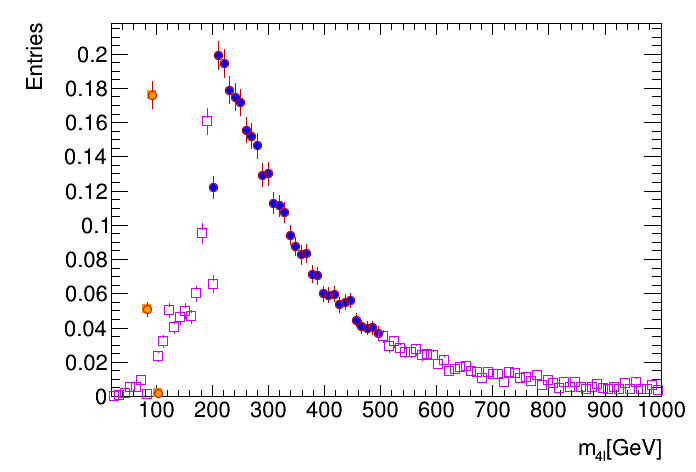

In [30]:
%%cpp 
    
// get the sample
Sample<MyAnalysisTree> mySample = makeSample_v1(); 
// load the input - NOTE: Usually, this is done for us automatically by the toolkit 
std::shared_ptr<TFile> f;
MyAnalysisTree t = mySample.getSortedInputFiles().at(0).getTreeFromFile(f); 
    
// Here, we define a few histos to draw - one per region.
// We deliberately do NOT use the RunHistoFiller populator. We would do this in real life 
// and be done immediately, but for this tutorial we explicitly want to show manually how 
// the fill instruction works. Hence we create an empty Plot and then manually add content 
// in the event loop below. 
Plot<TH1D> myHisto_HighMass_SR{ConstructInPlace<TH1D>("myHisto","m;m_{4l}[GeV];Entries",100,20,1000), 
                               PlotFormat().Color(kBlue)}; 
Plot<TH1D> myHisto_Z_SR{ConstructInPlace<TH1D>("myHisto","m;m_{4l}[GeV];Entries",100,20,1000), 
                               PlotFormat().Color(kOrange-3).MarkerStyle(kFullSquare)}; 
Plot<TH1D> myHisto_Combined_SR{ConstructInPlace<TH1D>("myHisto","m;m_{4l}[GeV];Entries",100,20,1000), 
                               PlotFormat().Color(kRed+1).MarkerStyle(kOpenCircle)}; 
Plot<TH1D> myHisto_Sideband_SR{ConstructInPlace<TH1D>("myHisto","m;m_{4l}[GeV];Entries",100,20,1000), 
                               PlotFormat().Color(kViolet).MarkerStyle(kOpenSquare)}; 
   
// Time for the event loop! 
for(int k = 0; k < t.getEntries(); ++k){
   // fetch the current entry
   t.getEntry(k);
    // and fill each plot if the appropriate selection is passed
   if (high_mass_SR(t)) massFiller(myHisto_HighMass_SR(), t);
   if (Z_mass_SR(t))    massFiller(myHisto_Z_SR(), t);
   if (combined_SR(t))  massFiller(myHisto_Combined_SR(), t);
   if (sideband_SR(t))  massFiller(myHisto_Sideband_SR(), t);
   /// Notice how this has essentially become a loop over selections and associated histograms? :-) 
   /// All the details are now contained in the user-specified building blocks 
    
}
f->Close();

// Now draw everything. We don't try to be too fancy here. 
TCanvas* c1 = new TCanvas(); 
c1->cd();
myHisto_HighMass_SR->Draw(); 
myHisto_Z_SR->Draw("same"); 
myHisto_Combined_SR->Draw("same"); 
myHisto_Sideband_SR->Draw("same"); 
c1->Draw(); 

And our fillers are working very nicely, as are the associated selections. Hooray! 

If you look at the event loop above, you will probably already get a good idea of the next logical step.

Since the event loop has become a simple loop over each selection, and for each selection over all histograms using it, we can fully automatize this. 

This is the idea behind the `RunHistoFiller` populator we talked about earlier, and the [HistoFiller](https://gitlab.cern.ch/goblirsc/NtupleAnalysisUtils/-/blob/master/NtupleAnalysisUtils/HistoFiller/HistoFiller.h) class doing the heavy lifting. 




# The HistoFiller - how it works

The `HistoFiller` has two main functions: 
* It book-keeps all the `Plot`s with a `RunHistoFiller` populator that the user has defined 
* When the first such `Plot` is populated by the user, it will run a multi-threaded (optional) event loop to fill all connected `Plot`s in one go

The entire functionality happens in the background, the user normally does not need to directly interact with it. 

Rather than spending a lot of time discussing details, let's jump in and make some plots! We'll reproduce the test figure above! 

Starting input file validation...
Finished input validation in 0 seconds
HistoFiller will run with up to 16 threads. 
>> 70035 / 79374 Events (88.23%) and 0/1 Files done after 0 s processing time. 1.65 MHz - E.T.A 0 s                 


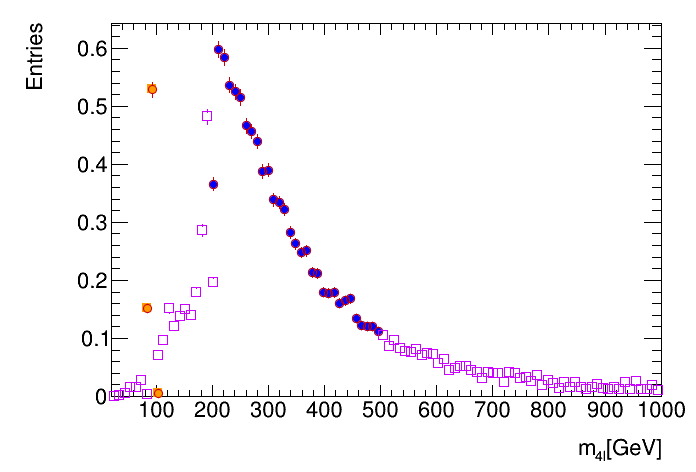

In [31]:
%%cpp 

// get the sample - three files to demonstrate MT
Sample<MyAnalysisTree> theSample = getCombinedSample(); 

// create an example histogram to define the binning of our plots 
TH1D h_example("myHisto","m;m_{4l}[GeV];Entries",100,20,1000); 


// define the four plots from before, but now using the HistoFiller mechanic!
Plot<TH1D> myHisto_HF_HighMass_SR{RunHistoFiller<TH1D, MyAnalysisTree>(&h_example, theSample, high_mass_SR,massFiller), 
                               PlotFormat().Color(kBlue)}; 
Plot<TH1D> myHisto_HF_Z_SR{RunHistoFiller<TH1D, MyAnalysisTree>(&h_example, theSample, Z_mass_SR,massFiller), 
                               PlotFormat().Color(kOrange-3).MarkerStyle(kFullSquare)}; 
Plot<TH1D> myHisto_HF_Combined_SR{RunHistoFiller<TH1D, MyAnalysisTree>(&h_example, theSample, combined_SR,massFiller), 
                               PlotFormat().Color(kRed+1).MarkerStyle(kOpenCircle)}; 
Plot<TH1D> myHisto_HF_Sideband_SR{RunHistoFiller<TH1D, MyAnalysisTree>(&h_example, theSample, sideband_SR,massFiller), 
                               PlotFormat().Color(kViolet).MarkerStyle(kOpenSquare)}; 

// Now draw everything. 
TCanvas* c1 = new TCanvas(); 
c1->cd();
myHisto_HF_HighMass_SR->Draw(); // for fun: This line will internally trigger the population of the plot and hence the event loop.  
myHisto_HF_Z_SR->Draw("same"); 
myHisto_HF_Combined_SR->Draw("same"); 
myHisto_HF_Sideband_SR->Draw("same"); 
c1->Draw(); 

You can see this was very easy. We invoke a new populator, called `RunHistoFiller`. 
This is templated to: 
* The object type to populate (here: TH1D)
* The object type to read from (here: MyAnalysisTree). 

And creating it takes four arguments: 
* A pointer to a "reference" ROOT object to copy the binning and axis titles / labels from. This is copied immediately and doesn't need to 'outlive' the `Plot` you make. 
* A `Sample` defining what to fill the `Plot` from 
* A `Selection` defining when to fill the `Plot` 
* A `PlotFillInstruction` defining how to fill the `Plot`. 

In other words, you plug in the blocks we discussed earlier and the code takes care of the rest. 

Of course, this is a `PlotPopulator` like any other, and can be daisy chained as input to other Populators as well! Can you write a populator that fills a unit-normalised histogram? 

So what is actually happening behind the scenes? 
* There is a 'HistoFiller' object lurking in the background 
* The `RunHistoFiller` populators talk to this object and 'book' the plot you asked for. No event loop is run at this time 
* When you first interact with a `Plot` with such a populator, **all** `Plot`s requiring ntuple processing defined to this time are filled in one go. To be maximally efficient, define everything you need before accessing any of the outputs. 
* To fill the plots when needed, the `HistoFiller` launches a multi-threaded processing loop, within which all the input files are looped over and every requested combination of file/selection/fill instruction/binning is accounted for 
* When you try to populate other `Plot`s for which the loop has already run, the `HistoFiller` will return a (fresh) copy of the already filled object, it will not re-run the fill loop unnecessarily. 

As a user, in 99% of all times you can forget about the `HistoFiller`'s details. It will do the work for you, and you just need to describe the desired functionality via the building blocks you hand to the populator. 

## The technical detail (feel free to skip) 
- Booking a `Plot` object with a `RunHistoFiller` populator essentially works like placing an order at a counter - it tells the [HistoFiller](https://gitlab.cern.ch:8443/Atlas-Inner-Tracking/NtupleAnalysisUtils/-/blob/master/NtupleAnalysisUtils/HistoFiller/HistoFiller.h) that you need a certain plot. The `HistoFiller` maintains a (dependency-sorted) list of the user-requested plots. 
- When the user first tries to interact with the content of one of the `Plot` objects, this will trigger the `HistoFiller` to start filling **all** the `Plot` objects booked so far, in one single loop. 
- To optimise performance, the `HistoFiller` automatically re-arranges the hierarchy of the user's requests into a dependency-graph-like structure: 
    - It will recognize all booked `Plot`s using the same input file, and run each file only once, filling all plots relying on it. 
    - `Plots` which require several files in their `Sample` are split into one `Plot` for every single file and automatically recombined later
    - The HistoFiller will then, for each file, factorise all booked `Plots` that use the same `Selection`, evaluating the `Selection` outcome only once 
    - Finally, it will also recognize similar fill instructions, and prevent work from being duplicated. 
    - As an extension of this, you can book an identical plot 1000 times, and you will only have the overhead of filling it once (while each booked instance will still be a unique copy). So there is no need for user-side optimisation / re-use of bookings, this is all taken care of in the background. 
    - Each independent (connected) graph is then run as a separate CPU thread, in order to exploit multi-core systems without encountering issues with ROOT's limited thread friendliness. 

For example, for two files, two regions and three observables, and for simplification assuming we run all regions for both files and all observables in all regions: 
![title](HiFiLogic.png)

## Advanced usage 

The `HistoFiller`, while living in the background, can be interacted with in order to configure the event loop.
To do so, call `HistoFiller::getDefaultFiller()`. 

### Debug printouts

For example, we can look at the current configuration and make it print any connected `Plot` objects: 

In [32]:
%%cpp 
HistoFiller::getDefaultFiller()->print(); 

HistoFiller will run with up to 16 threads. 
===== HistoFiller instance ==================================== 
    Number of threads: 16
    Splittable inputs: 1
    Connected plots (total): 4
    Fill Mode: Multi-Threaded
     --> Processing queue with 0 work items:


### Configuring multithreading behaviour 

Let's assume you don't want to run Multithreading, for example because you are running on shared resources and wish to be a responsible citizen. 

(the little MT devil says: Doooooo it anyway!) 

You can configure the number of threads to use in two ways. Either by exporting the `NTAU_NTHREADS` environment variable, for example 
``` NTAU_NTHREADS=2 myProgram``` would be limited to using two threads, or by calling 

```
HistoFiller::getDefaultFiller()->setNThreads(2); 
```
... or you can even disable MT altogether via 
```
HistoFiller::getDefaultFiller()->setFillMode(HistoFillMode::singleThread);
``` 

### Manipulating the payload

This is not usually required, unless you are interested in benchmarking. 
You can make the `HistoFiller` completely forget about all connected objects via 
```
HistoFiller::getDefaultFiller()->DisconnectAll(); 
```
This will make plots previously booked via the `RunHistoFiller` populator, unless already filled, disconnected and defunct. 

Alternatively, you can keep your `Plot`s attached but for a repeat of the event loop, for example to benchmark various threading options. 
This can be done via ```HistoFiller::getDefaultFiller()->ResetFillResults()```; 

## Identifiers (for advanced users)

As explained earlier, the `HistoFiller` organises its attached plots for maximum efficiency by recognizing re-use of common input files, selections or fillers.

This happens automatically by assigning a unique identifier to each such building block when it gets created.

While this is guaranteed to yield correct results, there are cases where the user might want to manually assign UIDs. 

For example, imagine the following utility function which creates a selection for us: 

In [33]:
%%cpp -d
Selection<MyAnalysisTree> BuildMassWindow(double m_low, double m_high){
    return Selection<MyAnalysisTree>{[m_low, m_high](MyAnalysisTree &t){ return m_low < t.m4l() && t.m4l() < m_high;}};  
}

Now what happens if we attach two identical windows made using the helper to our filler? 

In [34]:
%%cpp
TH1D h_forBinning("myHisto","m;m_{4l}[GeV];Entries",100,20,1000); 
HistoFiller::getDefaultFiller()->DisconnectAll(); 
Plot<TH1D> plot1(RunHistoFiller<TH1D, MyAnalysisTree>(&h_forBinning, theSample, BuildMassWindow(10,20), massFiller )); 
Plot<TH1D> plot2(RunHistoFiller<TH1D, MyAnalysisTree>(&h_forBinning, theSample, BuildMassWindow(10,20), massFiller )); 
HistoFiller::getDefaultFiller()->print(); 

HistoFiller will run with up to 16 threads. 
===== HistoFiller instance ==================================== 
    Number of threads: 16
    Splittable inputs: 1
    Connected plots (total): 2
    Fill Mode: Multi-Threaded
     --> Processing queue with 1 work items:
     --> HistoFillTask with the following properties: 
        ID: [ 1171574683204593067 2623774440800785194 ]
        File: DemoTree.root
        Tree: SM4L_Nominal
        Bootstrap Toys: 0
        Reporting Interval: 100
        Number of selections to process: 2
        --> Selection with ID [ 352 ] and 3 objects to fill :
                --> Fillable with ID [ 1171574683204593067 2623774440800785194 1171574683204593067 2623774440800785194 1171574683204593067 2623774440800785194 352 89 -8510844262313800074 ]
                --> Fillable with ID [ 1171574683204593067 2623774440800785194 1171574683204593067 2623774440800785194 1171574683204593067 2623774440800785194 352 89 -8510844262313800074 ]
                --> Fillab

The code sees two selections! This is because, by default, each Selection is assigned a fresh UID upon creation.
This will create a little overhead. While in our example, this would be harmless, it can hurt if you accidentally duplicate complex logic, 

Side node: You see three `Fillable` objects because our one file was specified to be processed three times when we defined the sample earlier. 
You can see that the code has detected the files to be identical. 
It will in fact just run once (1 "work item") and then triplicate the output.  

Now, assume we want to speed this up by ensuring identical mass windows resolve to the same UID? You can manually specify UIDs! They can be created from strings. 
**Careful**: When you manually specify UIDs, it's your job to ensure they really are unique... 

You can set identifiers using the ```setID``` method. Let's write an example for a selection generator that accounts for identical windows: 

In [35]:
%%cpp -d
Selection<MyAnalysisTree> BuildMassWindowWithUID(double m_low, double m_high){
    auto sel = Selection<MyAnalysisTree>{[m_low, m_high](MyAnalysisTree &t){ return m_low < t.m4l() && t.m4l() < m_high;}};  
    sel.setID("MassWindow_"+std::to_string(m_low)+"_"+std::to_string(m_high));  // force UID
    return sel; 
}

In [36]:
%%cpp
TH1D h_forBinning("myHisto","m;m_{4l}[GeV];Entries",100,20,1000); 
HistoFiller::getDefaultFiller()->DisconnectAll(); 
Plot<TH1D> plot1(RunHistoFiller<TH1D, MyAnalysisTree>(&h_forBinning, theSample, BuildMassWindowWithUID(10,20), massFiller )); 
Plot<TH1D> plot2(RunHistoFiller<TH1D, MyAnalysisTree>(&h_forBinning, theSample, BuildMassWindowWithUID(10,20), massFiller )); 
HistoFiller::getDefaultFiller()->print(); 

HistoFiller will run with up to 16 threads. 
===== HistoFiller instance ==================================== 
    Number of threads: 16
    Splittable inputs: 1
    Connected plots (total): 1
    Fill Mode: Multi-Threaded
     --> Processing queue with 1 work items:
     --> HistoFillTask with the following properties: 
        ID: [ 1171574683204593067 2623774440800785194 ]
        File: DemoTree.root
        Tree: SM4L_Nominal
        Bootstrap Toys: 0
        Reporting Interval: 100
        Number of selections to process: 1
        --> Selection with ID [ -2588410718426956347 ] and 3 objects to fill :
                --> Fillable with ID [ 1171574683204593067 2623774440800785194 1171574683204593067 2623774440800785194 1171574683204593067 2623774440800785194 -2588410718426956347 89 -8510844262313800074 ]
                --> Fillable with ID [ 1171574683204593067 2623774440800785194 1171574683204593067 2623774440800785194 1171574683204593067 2623774440800785194 -2588410718426956347 8

And now the `HistoFiller` has recognized the two generated selections are identical! 

The same can be done for fill instructions. Technically, it can also be done for input files, but here the file name and tree name are automatically picked up, which should prevent any duplication. 

# What next? 

Congratulations, if you are reading this you know how to use the `HistoFiller` to meet your histogramming needs! 

In the next part, we will play with some nice pre-made drawing features for visualising the fruit of your labour! 